In [20]:
import numpy as np
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential, load_model
from keras.callbacks import Callback
# import keras.backend.tensorflow_backend as KTF
import tensorflow as tf
import pandas as pd
import os
import  keras.callbacks
import matplotlib.pyplot as plt
 
#设定为自增长

#设定为自增长

# #原版 config = tf.ConfigProto(allow_soft_placement=True)
# config = tf.compat.v1.ConfigProto(allow_soft_placement=True)
# #原版 sess = tf.Session(config=config)
# sess =tf.compat.v1.Session(config=config)  #注意 ，这里为tensorflow2.0版本，与第1.0有差距。

# config = tf.ConfigProto()
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
# session = tf.Session(config=config)
session = tf.compat.v1.Session(config=config)
# KTF.set_session(session)

# keras.backend.tensorflow_backend.set_session(tf.compat.v1.Session(config=config))
tf.compat.v1.keras.backend.set_session(session)
 

In [21]:
def create_dataset(data,n_predictions,n_next):
    '''
    对数据进行处理
    '''
    dim = data.shape[1]
    train_X, train_Y = [], []
    for i in range(data.shape[0]-n_predictions-n_next-1):
        a = data[i:(i+n_predictions), :]
        train_X.append(a)
        tempb = data[(i+n_predictions):(i+n_predictions+n_next), :]
        b = []
        for j in range(len(tempb)):
            for k in range(dim):
                b.append(tempb[j, k])
        train_Y.append(b)
    train_X = np.array(train_X, dtype='float64')
    train_Y = np.array(train_Y, dtype='float64')
 
    test_X, test_Y = [], []
    i = data.shape[0]-n_predictions-n_next-1
    a = data[i:(i + n_predictions), :]
    test_X.append(a)
    tempb = data[(i + n_predictions):(i + n_predictions + n_next), :]
    b = []
    for j in range(len(tempb)):
        for k in range(dim):
            b.append(tempb[j, k])
    test_Y.append(b)
    test_X = np.array(test_X, dtype='float64')
    test_Y = np.array(test_Y, dtype='float64')
 
    return train_X, train_Y, test_X, test_Y
 

In [22]:
def NormalizeMult(data, set_range):
    '''
    返回归一化后的数据和最大最小值
    '''
    normalize = np.arange(2*data.shape[1], dtype='float64')
    normalize = normalize.reshape(data.shape[1], 2)
 
    for i in range(0, data.shape[1]):
        if set_range == True:
            list = data[:, i]
            listlow, listhigh = np.percentile(list, [0, 100])
        else:
            if i == 0:
                listlow = -90
                listhigh = 90
            else:
                listlow = -180
                listhigh = 180
 
        normalize[i, 0] = listlow
        normalize[i, 1] = listhigh
 
        delta = listhigh - listlow
        if delta != 0:
            for j in range(0, data.shape[0]):
                data[j, i] = (data[j, i] - listlow)/delta
 
    return data, normalize
 

In [25]:
def trainModel(train_X, train_Y):
    '''
    trainX，trainY: 训练LSTM模型所需要的数据
    '''
    model = Sequential()
    model.add(LSTM(
        120,
        input_shape=(train_X.shape[1], train_X.shape[2]),
        return_sequences=True))
    model.add(Dropout(0.3))
 
    model.add(LSTM(
        120,
        return_sequences=False))
    model.add(Dropout(0.3))
 
    model.add(Dense(
        train_Y.shape[1]))
    model.add(Activation("relu"))
 
    model.compile(loss='mse', optimizer='adam', metrics=['acc'])
    model.fit(train_X, train_Y, epochs=30, batch_size=64, verbose=1)
    model.summary()
 
    return model
 

样本数：9000，维度：2


<IPython.core.display.Javascript object>


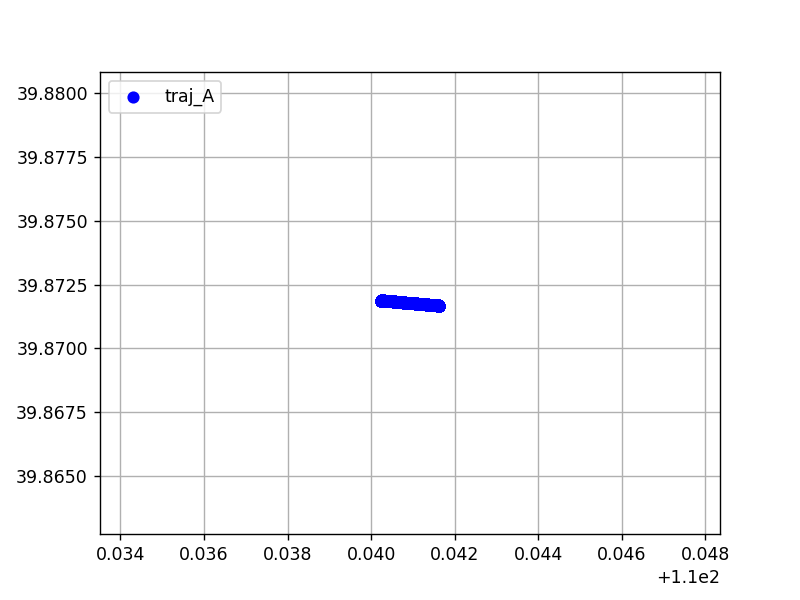

x
 (8992, 6, 2)
y
 (8992, 2)


In [26]:
if __name__ == "__main__":
    train_num = 6
    per_num = 1
    # set_range = False
    set_range = True
 
    # 读入时间序列的文件数据
    data=np.loadtxt('20210329_163041_1_ccu.csv',dtype=float,delimiter=',',skiprows = 1,usecols = (3,4),encoding = 'gb18030')
    print("样本数：{0}，维度：{1}".format(data.shape[0], data.shape[1]))
    # print(data)
 
    # 画样本数据库
    %matplotlib notebook
    plt.scatter(data[:, 1], data[:, 0], c='b', marker='o', label='traj_A')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()
 
    #归一化
    data, normalize = NormalizeMult(data, set_range)
    # print(normalize)
 
    #生成训练数据
    train_X, train_Y, test_X, test_Y = create_dataset(data, train_num, per_num)
    print("x\n", train_X.shape)
    print("y\n", train_Y.shape)
 

In [27]:
  
    # 训练模型
    model = trainModel(train_X, train_Y)
    loss, accuracy = model.evaluate(train_X, train_Y, verbose=2)
    print('Loss : {}, Accuracy: {}'.format(loss, accuracy))
 
    # 保存模型
    np.save("./traj_model_trueNorm.npy", normalize)
    model.save("./traj_model_120.h5")

Epoch 1/30
8992/8992 [==============================] - 3s 278us/step - loss: 0.0166 - acc: 0.9633
Epoch 2/30
8992/8992 [==============================] - 2s 224us/step - loss: 0.0028 - acc: 0.9879
Epoch 3/30
8992/8992 [==============================] - 2s 230us/step - loss: 0.0026 - acc: 0.9900
Epoch 4/30
8992/8992 [==============================] - 2s 229us/step - loss: 0.0024 - acc: 0.9902
Epoch 5/30
8992/8992 [==============================] - 2s 226us/step - loss: 0.0023 - acc: 0.9919
Epoch 6/30
8992/8992 [==============================] - 2s 224us/step - loss: 0.0022 - acc: 0.9903
Epoch 7/30
8992/8992 [==============================] - 2s 226us/step - loss: 0.0021 - acc: 0.9907
Epoch 8/30
8992/8992 [==============================] - 2s 225us/step - loss: 0.0020 - acc: 0.9923
Epoch 9/30
8992/8992 [==============================] - 2s 238us/step - loss: 0.0019 - acc: 0.9937
Epoch 10/30
8992/8992 [==============================] - 2s 250us/step - loss: 0.0018 - acc: 0.9928
Epoch 11/

In [28]:
import numpy as np
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential, load_model
from keras.callbacks import Callback
# import keras.backend.tensorflow_backend as KTF
import tensorflow as tf
import  pandas as pd
import  os
import  keras.callbacks
import matplotlib.pyplot as plt
import copy
 
# config = tf.ConfigProto()
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
# session = tf.Session(config=config)
session = tf.compat.v1.Session(config=config)
# KTF.set_session(session)
tf.compat.v1.keras.backend.set_session(session)
    
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
def mse(predictions, targets):
    return ((predictions - targets) ** 2).mean()
 
def reshape_y_hat(y_hat,dim):
    re_y = []
    i = 0
    while i < len(y_hat):
        tmp = []
        for j in range(dim):
            tmp.append(y_hat[i+j])
        i = i + dim
        re_y.append(tmp)
    re_y = np.array(re_y, dtype='float64')
    return re_y
 
#多维反归一化
def FNormalizeMult(data,normalize):
 
    data = np.array(data, dtype='float64')
    #列
    for i in range(0, data.shape[1]):
        listlow = normalize[i, 0]
        listhigh = normalize[i, 1]
        delta = listhigh - listlow
        print("listlow, listhigh, delta", listlow, listhigh, delta)
        #行
        if delta != 0:
            for j in range(0, data.shape[0]):
                data[j, i] = data[j, i]*delta + listlow
 
    return data
 
#使用训练数据的归一化
def NormalizeMultUseData(data,normalize):
 
    for i in range(0, data.shape[1]):
 
        listlow = normalize[i, 0]
        listhigh = normalize[i, 1]
        delta = listhigh - listlow
 
        if delta != 0:
            for j in range(0, data.shape[0]):
                data[j, i] = (data[j, i] - listlow)/delta
 
    return data
 
from math import sin, asin, cos, radians, fabs, sqrt
 
EARTH_RADIUS = 6371  # 地球平均半径，6371km
 
# 计算两个经纬度之间的直线距离
def hav(theta):
    s = sin(theta / 2)
    return s * s
def get_distance_hav(lat0, lng0, lat1, lng1):
    # "用haversine公式计算球面两点间的距离。"
    # 经纬度转换成弧度
    lat0 = radians(lat0)
    lat1 = radians(lat1)
    lng0 = radians(lng0)
    lng1 = radians(lng1)
 
    dlng = fabs(lng0 - lng1)
    dlat = fabs(lat0 - lat1)
    h = hav(dlat) + cos(lat0) * cos(lat1) * hav(dlng)
    distance = 2 * EARTH_RADIUS * asin(sqrt(h))
    return distance
 

In [42]:
from numpy import newaxis

if __name__ == '__main__':
    test_num = 6
    per_num = 1
        
    data1=np.loadtxt('20210329_163041_1_ccu.csv',dtype=float,delimiter=',',skiprows = 1,usecols = (3,4),encoding = 'gb18030')

    data_all = data1[-2*(test_num+per_num):-1*(test_num+per_num), 0:2]
    data_all.dtype = 'float64'
    print(data_all)

[[ 39.8716788 110.0416272]
 [ 39.8716788 110.0416272]
 [ 39.8716788 110.0416272]
 [ 39.8716788 110.0416272]
 [ 39.8716787 110.0416279]
 [ 39.8716787 110.0416279]
 [ 39.8716787 110.0416279]]


In [43]:
    data = copy.deepcopy(data_all[:-per_num, :])
    y = data_all[-per_num:, :]
  

In [44]:
    # #归一化
    normalize = np.load("./traj_model_trueNorm.npy")
    data = NormalizeMultUseData(data, normalize)
 

In [45]:
    model = load_model("./traj_model_120.h5",compile=False)
    

In [115]:
    test_X = data.reshape(1, data.shape[0], data.shape[1])
    y_hat = model.predict(test_X)
    y_hat = y_hat.reshape(y_hat.shape[1])
    y_hat = reshape_y_hat(y_hat, 2)
 
    curr_frame = test_X
    curr_frame.shape

(1, 6, 2)

In [116]:
#     predicted = []
#     predicted.append(model.predict(curr_frame)[0])
#     predicted[-1]
    

In [117]:
#     curr_frame = curr_frame[:,1:,:]
#     a=np.append(curr_frame[0],predicted[-1])
#     a.reshape(test_X.shape)


In [119]:
#     for i in range(6):
#         predicted.append(model.predict(curr_frame)[0])
#         curr_frame = curr_frame[:,1:,:]
#         print(curr_frame.shape)
#         a=np.append(curr_frame[0],predicted[-1])
#         curr_frame=a.reshape(test_X.shape)    
#     predicted

(1, 5, 2)
(1, 5, 2)
(1, 5, 2)
(1, 5, 2)
(1, 5, 2)
(1, 5, 2)


[array([0.       , 1.0072551], dtype=float32),
 array([0.       , 1.0077301], dtype=float32),
 array([0.       , 1.0084848], dtype=float32),
 array([0.       , 1.0093904], dtype=float32),
 array([0.       , 1.0103675], dtype=float32),
 array([0.       , 1.0113012], dtype=float32),
 array([0.       , 1.0122527], dtype=float32),
 array([0.       , 1.0126183], dtype=float32),
 array([0.       , 1.0129964], dtype=float32),
 array([0.      , 1.013348], dtype=float32),
 array([0.      , 1.013653], dtype=float32),
 array([0.       , 1.0139031], dtype=float32)]

In [34]:
    #反归一化
    y_hat = FNormalizeMult(y_hat, normalize)
    print("predict: {0}\ntrue：{1}".format(y_hat, y))
    print('预测均方误差：', mse(y_hat, y))
    print('预测直线距离：{:.4f} KM'.format(get_distance_hav(y_hat[0, 0], y_hat[0, 1], y[0, 0], y[0, 1])))
 

listlow, listhigh, delta 39.8716786 39.8718761 0.00019749999999874035
listlow, listhigh, delta 110.040233 110.0416292 0.001396200000002068
predict: [[ 39.8716786  110.04163933]]
true：[[ 39.8716787 110.0416279]]
预测均方误差： 6.532218104464679e-11
预测直线距离：0.0010 KM


<IPython.core.display.Javascript object>


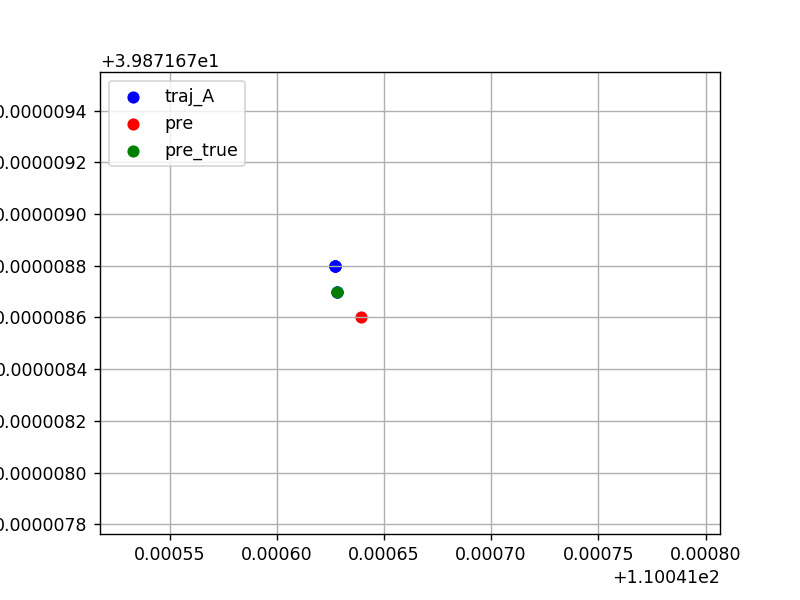

In [35]:
    %matplotlib notebook
   
    # 画测试样本数据库
    p1 = plt.scatter(data_all[:-per_num, 1], data_all[:-per_num, 0], c='b', marker='o', label='traj_A')
    p2 = plt.scatter(y_hat[:, 1], y_hat[:, 0], c='r', marker='o', label='pre')
    p3 = plt.scatter(y[:, 1], y[:, 0], c='g', marker='o', label='pre_true')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()